In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TRAIN:TEST = 7:3

In [2]:
# 1. Import thư viện cần thiết
from google.colab import drive
#drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắng index với giá AQI
df = pd.read_csv('/content/drive/MyDrive/LSTM/Data/DaNang.csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df[df['date'] <= '2024-06-01']
df1=df.reset_index()['AQI']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))
train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)


#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu test_predict
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
ytest1 = scaler.inverse_transform(ytest.reshape(-1,1))

Epoch 1/100
33/33 [==============================] - 13s 159ms/step - loss: 0.0094
Epoch 2/100
33/33 [==============================] - 7s 219ms/step - loss: 0.0072
Epoch 3/100
33/33 [==============================] - 6s 169ms/step - loss: 0.0071
Epoch 4/100
33/33 [==============================] - 6s 193ms/step - loss: 0.0071
Epoch 5/100
33/33 [==============================] - 6s 185ms/step - loss: 0.0069
Epoch 6/100
33/33 [==============================] - 5s 157ms/step - loss: 0.0068
Epoch 7/100
33/33 [==============================] - 7s 219ms/step - loss: 0.0067
Epoch 8/100
33/33 [==============================] - 5s 154ms/step - loss: 0.0064
Epoch 9/100
33/33 [==============================] - 6s 184ms/step - loss: 0.0064
Epoch 10/100
33/33 [==============================] - 6s 186ms/step - loss: 0.0059
Epoch 11/100
33/33 [==============================] - 5s 155ms/step - loss: 0.0055
Epoch 12/100
33/33 [==============================] - 7s 223ms/step - loss: 0.0053
Epoch 13/100

In [3]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE,MAPE
rmse = np.sqrt(mean_squared_error(ytest1 , test_predict))
mae = mean_absolute_error(ytest1 , test_predict)
mape = mean_absolute_percentage_error(ytest1 , test_predict)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 87.19906425155543
MAE: 39.57238499876999
MAPE: 0.5102464365938625


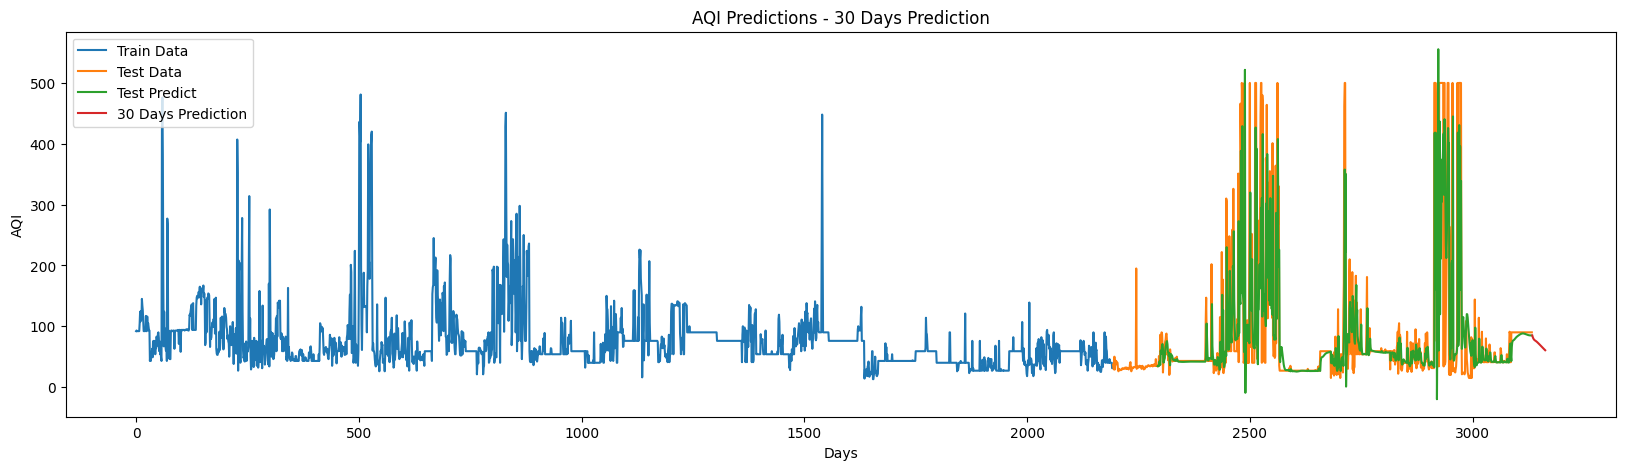

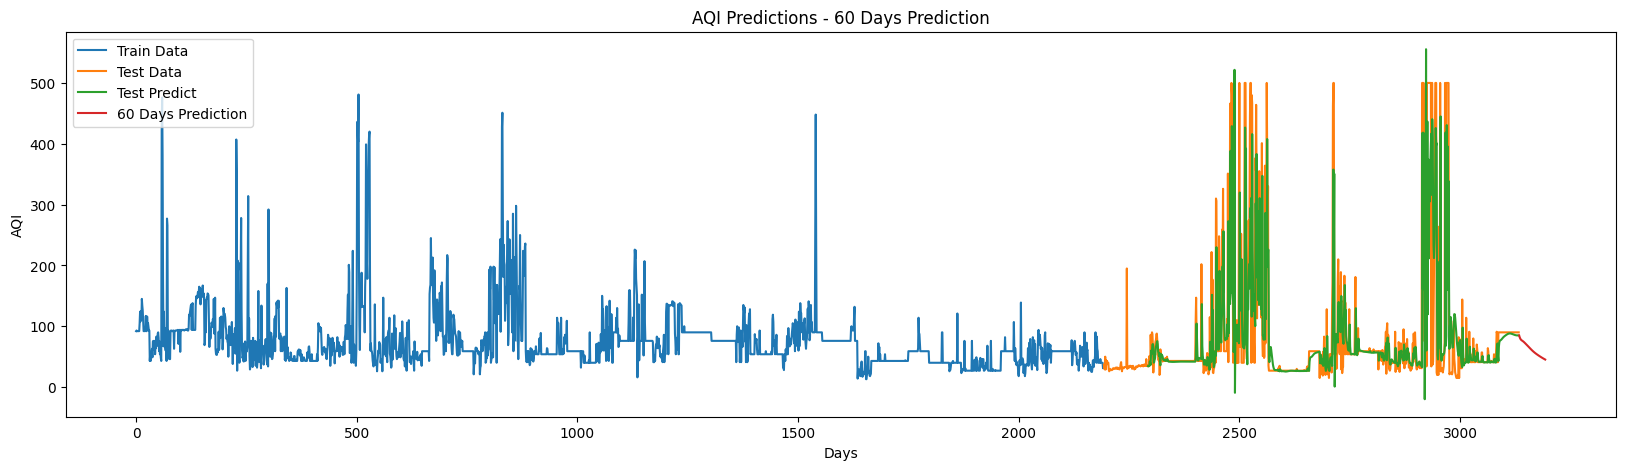

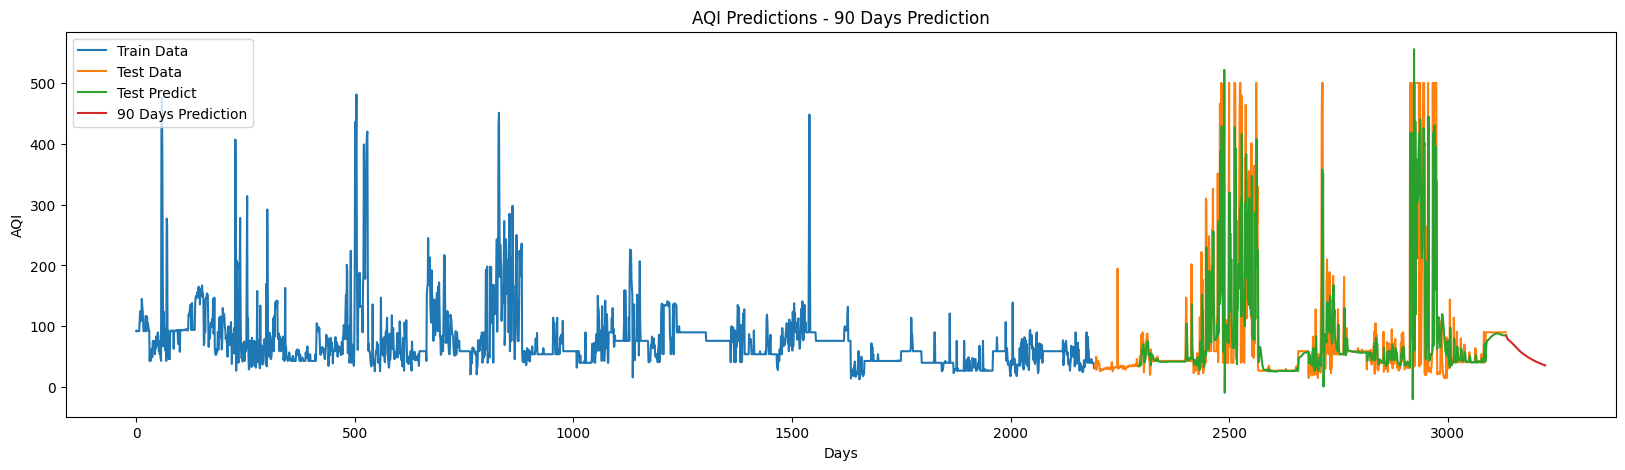

In [4]:
# 13. Tạo hàm dự đoán
def predict_future(model, data, time_step, future_days):
    temp_input = data[-time_step:].reshape(1, -1)
    temp_input = list(temp_input[0])
    future_output = []

    for _ in range(future_days):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]
        input_data = np.array(temp_input).reshape(1, time_step, 1)
        prediction = model.predict(input_data, verbose=0)
        temp_input.append(prediction[0][0])
        future_output.append(prediction[0][0])

    future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))
    return future_output

# 14. Dự đoán 30, 60, 90 ngày
future_30_days = predict_future(model, df1, time_step, 30)
future_60_days = predict_future(model, df1, time_step, 60)
future_90_days = predict_future(model, df1, time_step, 90)

# 15. Hàm trực quan dữ liệu
def create_plot(future_days, future_data, future_label):
    plt.figure(figsize=(20, 5))

    # Plot train data
    plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
    plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
    plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
    plt.plot(np.arange(len(df1), len(df1) + future_days), future_data, label=future_label)

    # Add labels and legend
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.title(f'AQI Predictions - {future_label}')
    plt.legend()
    plt.show()

# 16. Create plots
create_plot(30, future_30_days, '30 Days Prediction')
create_plot(60, future_60_days, '60 Days Prediction')
create_plot(90, future_90_days, '90 Days Prediction')

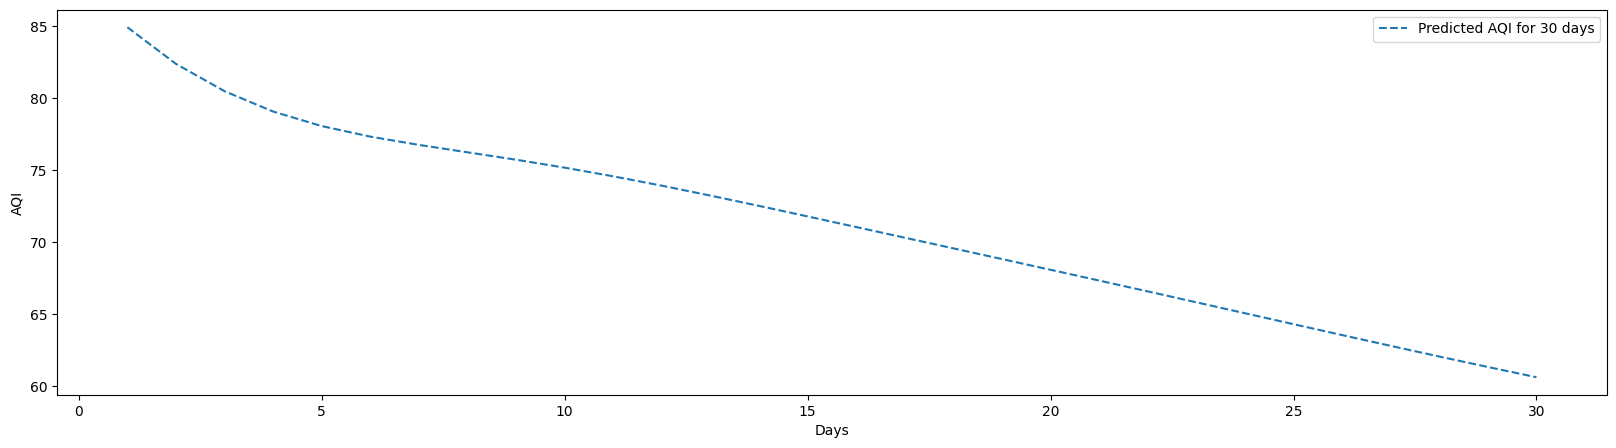

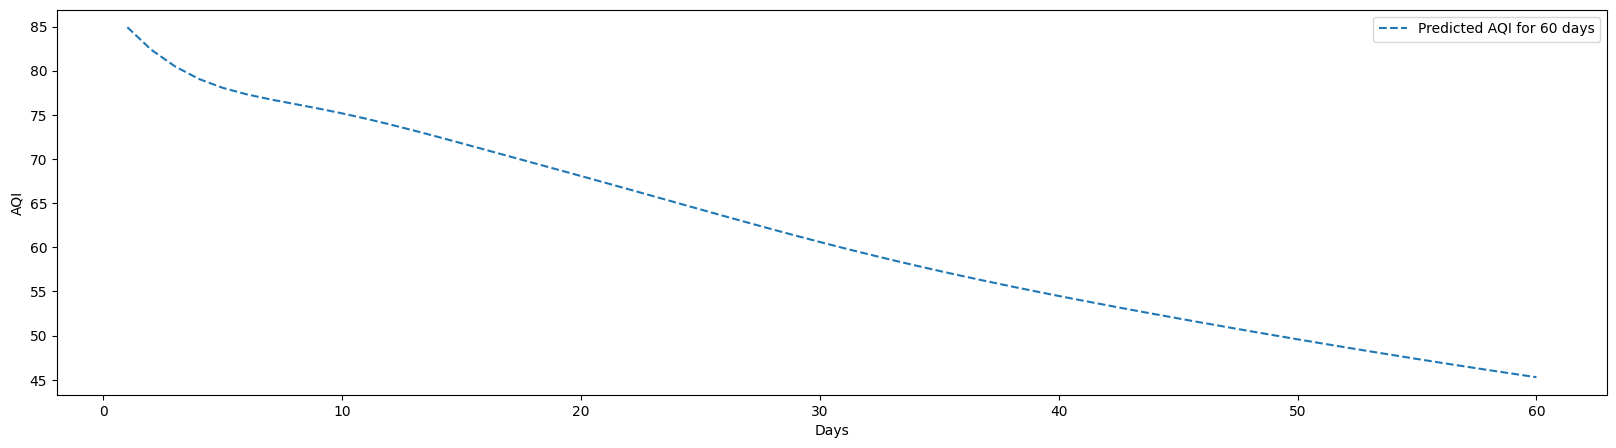

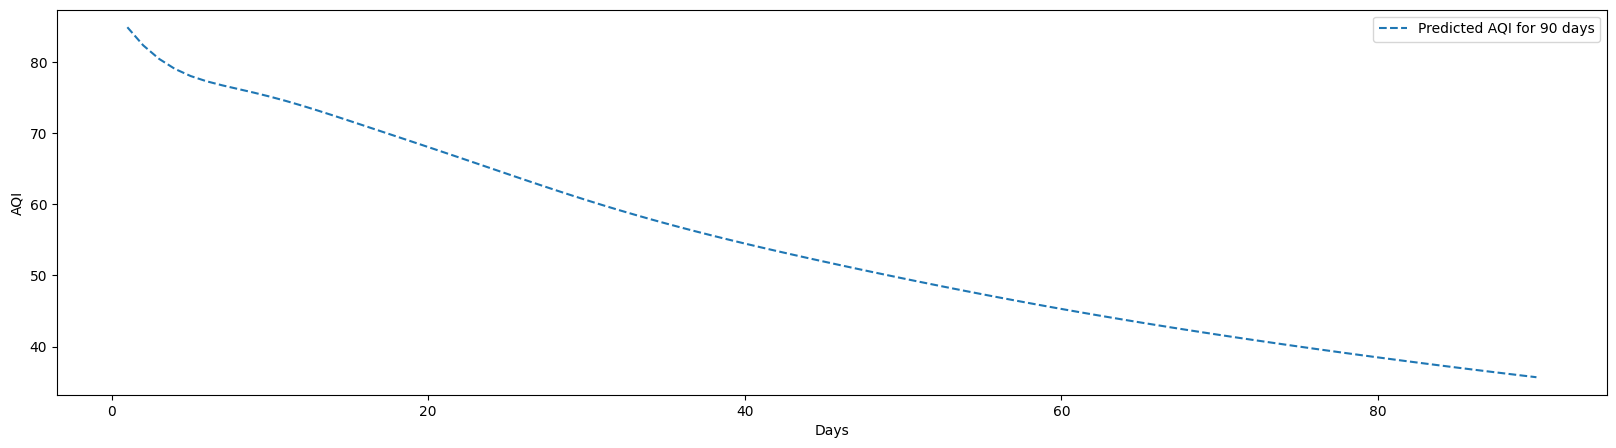

In [5]:
# Dự đoán chỉ số AQI theo 30. 60 và 90 ngày
for days in [30, 60, 90]:
    future_days = predict_future(model, df1, time_step, days)
    plt.figure(figsize=(20, 5))
    plt.plot(range(1, days + 1), future_days, label=f'Predicted AQI for {days} days', linestyle='--')
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

TRAIN:TEST = 8:2

In [6]:
# 1. Import thư viện cần thiết
from google.colab import drive
#drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắng index với giá AQI
df = pd.read_csv('/content/drive/MyDrive/LSTM/Data/DaNang.csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df[df['date'] <= '2024-06-01']
df1=df.reset_index()['AQI']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))
train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)


#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu test_predict
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
ytest1 = scaler.inverse_transform(ytest.reshape(-1,1))

Epoch 1/100
38/38 [==============================] - 14s 220ms/step - loss: 0.0110
Epoch 2/100
38/38 [==============================] - 6s 159ms/step - loss: 0.0089
Epoch 3/100
38/38 [==============================] - 8s 218ms/step - loss: 0.0087
Epoch 4/100
38/38 [==============================] - 6s 161ms/step - loss: 0.0085
Epoch 5/100
38/38 [==============================] - 8s 202ms/step - loss: 0.0084
Epoch 6/100
38/38 [==============================] - 6s 164ms/step - loss: 0.0082
Epoch 7/100
38/38 [==============================] - 7s 182ms/step - loss: 0.0078
Epoch 8/100
38/38 [==============================] - 7s 185ms/step - loss: 0.0076
Epoch 9/100
38/38 [==============================] - 6s 159ms/step - loss: 0.0075
Epoch 10/100
38/38 [==============================] - 8s 212ms/step - loss: 0.0073
Epoch 11/100
38/38 [==============================] - 6s 162ms/step - loss: 0.0071
Epoch 12/100
38/38 [==============================] - 8s 213ms/step - loss: 0.0068
Epoch 13/100

In [7]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE,MAPE
rmse = np.sqrt(mean_squared_error(ytest1 , test_predict))
mae = mean_absolute_error(ytest1 , test_predict)
mape = mean_absolute_percentage_error(ytest1 , test_predict)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 100.42420336865578
MAE: 48.038507015532865
MAPE: 0.8303032907296796


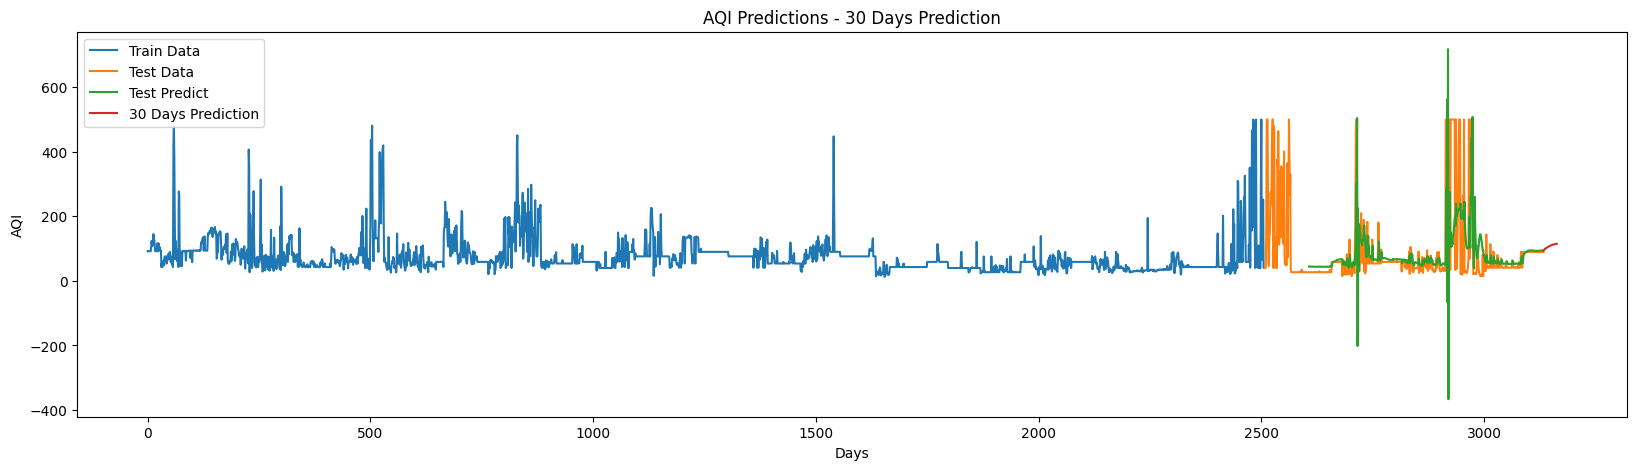

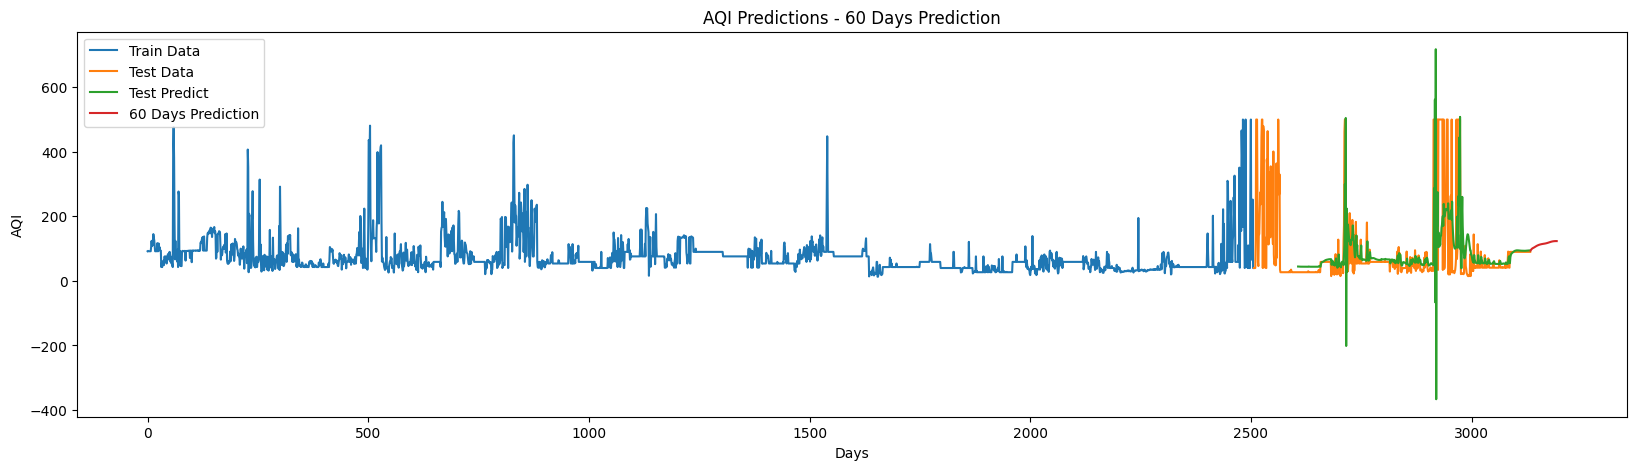

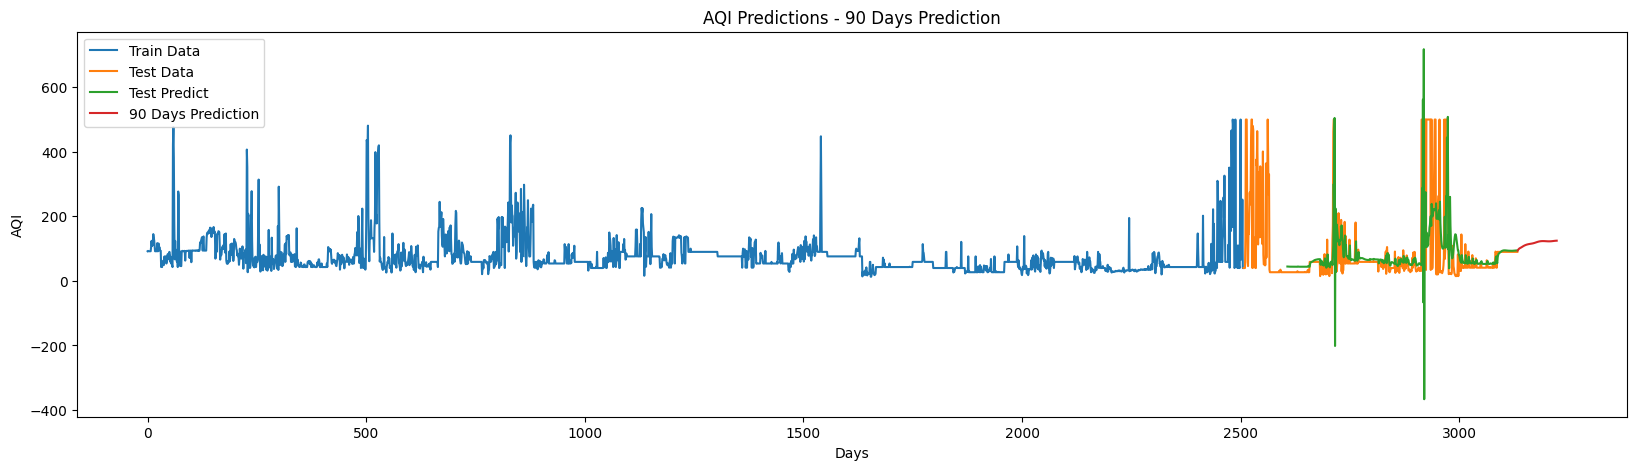

In [8]:
# 13. Tạo hàm dự đoán
def predict_future(model, data, time_step, future_days):
    temp_input = data[-time_step:].reshape(1, -1)
    temp_input = list(temp_input[0])
    future_output = []

    for _ in range(future_days):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]
        input_data = np.array(temp_input).reshape(1, time_step, 1)
        prediction = model.predict(input_data, verbose=0)
        temp_input.append(prediction[0][0])
        future_output.append(prediction[0][0])

    future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))
    return future_output

# 14. Dự đoán 30, 60, 90 ngày
future_30_days = predict_future(model, df1, time_step, 30)
future_60_days = predict_future(model, df1, time_step, 60)
future_90_days = predict_future(model, df1, time_step, 90)

# 15. Hàm trực quan dữ liệu
def create_plot(future_days, future_data, future_label):
    plt.figure(figsize=(20, 5))

    # Plot train data
    plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
    plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
    plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
    plt.plot(np.arange(len(df1), len(df1) + future_days), future_data, label=future_label)

    # Add labels and legend
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.title(f'AQI Predictions - {future_label}')
    plt.legend()
    plt.show()

# 16. Create plots
create_plot(30, future_30_days, '30 Days Prediction')
create_plot(60, future_60_days, '60 Days Prediction')
create_plot(90, future_90_days, '90 Days Prediction')

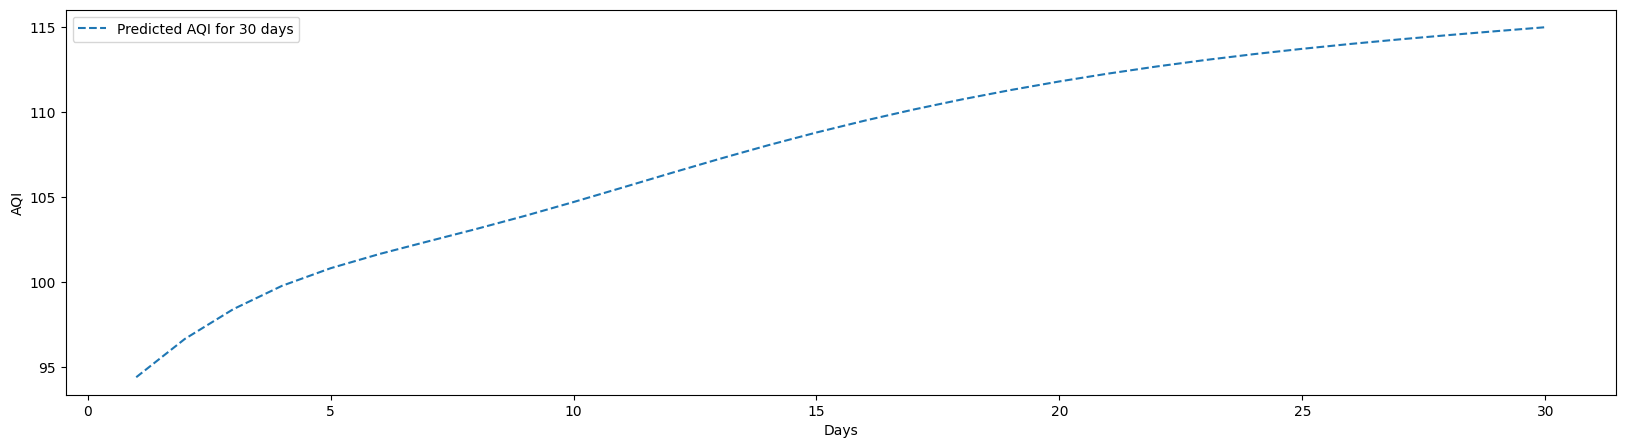

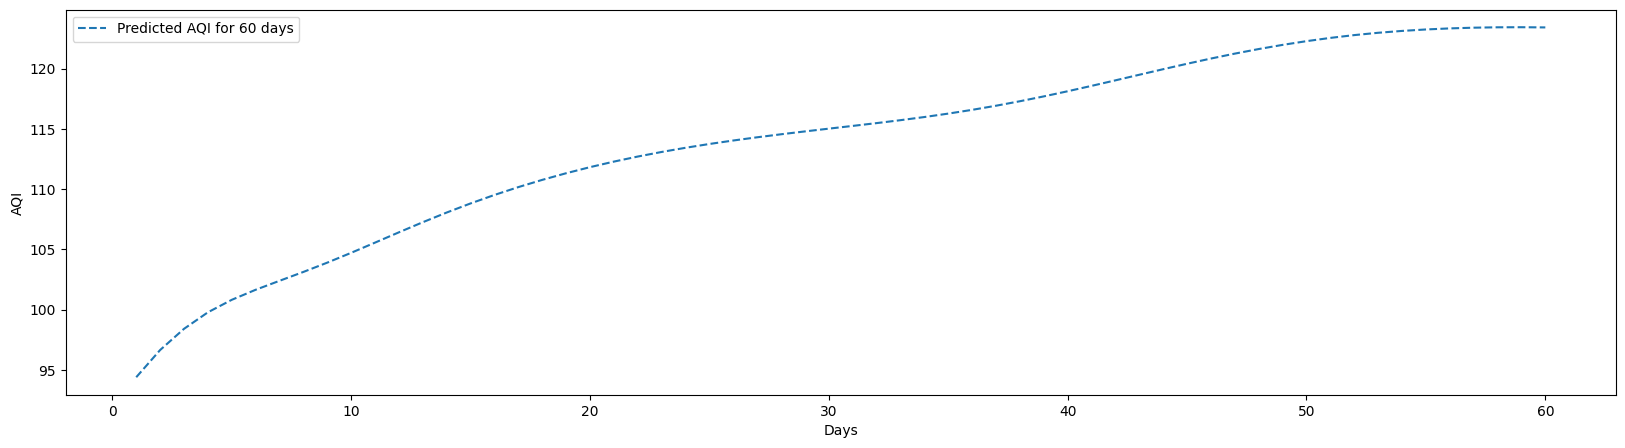

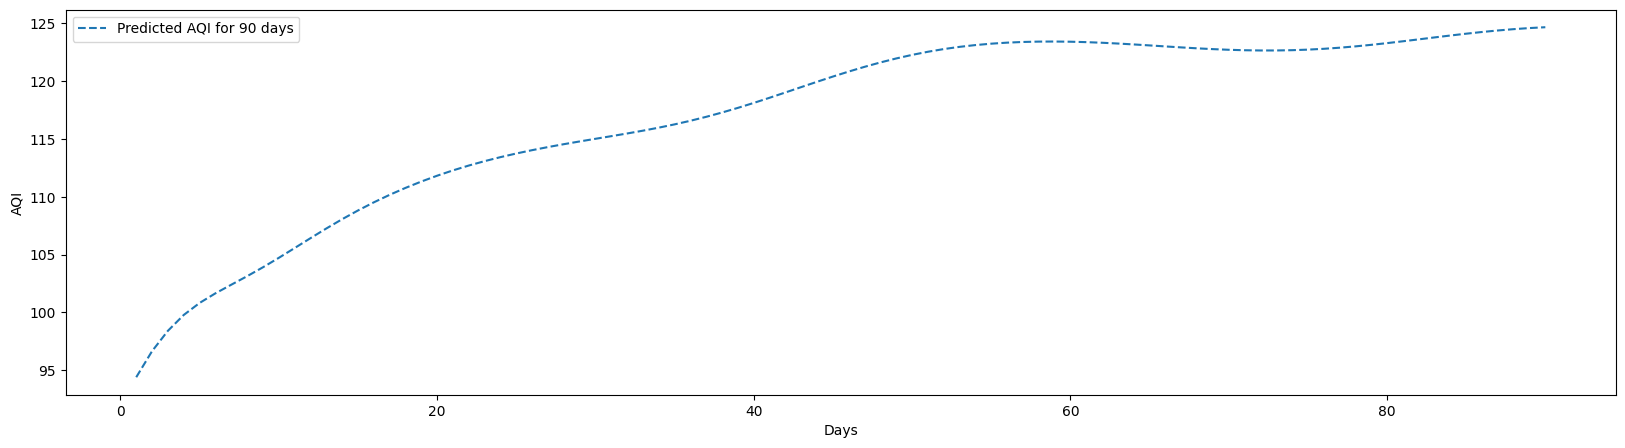

In [9]:
# Dự đoán chỉ số AQI theo 30. 60 và 90 ngày
for days in [30, 60, 90]:
    future_days = predict_future(model, df1, time_step, days)
    plt.figure(figsize=(20, 5))
    plt.plot(range(1, days + 1), future_days, label=f'Predicted AQI for {days} days', linestyle='--')
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

TRAIN:TEST = 9:1

In [10]:
# 1. Import thư viện cần thiết
from google.colab import drive
#drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắng index với giá AQI
df = pd.read_csv('/content/drive/MyDrive/LSTM/Data/DaNang.csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df[df['date'] <= '2024-06-01']
df1=df.reset_index()['AQI']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1))
train_data = df1[:train_size]
test_data = df1[train_size:]
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)


#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu test_predict
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
ytest1 = scaler.inverse_transform(ytest.reshape(-1,1))

Epoch 1/100
43/43 [==============================] - 15s 199ms/step - loss: 0.0144
Epoch 2/100
43/43 [==============================] - 8s 176ms/step - loss: 0.0123
Epoch 3/100
43/43 [==============================] - 9s 215ms/step - loss: 0.0124
Epoch 4/100
43/43 [==============================] - 7s 154ms/step - loss: 0.0122
Epoch 5/100
43/43 [==============================] - 9s 205ms/step - loss: 0.0116
Epoch 6/100
43/43 [==============================] - 7s 158ms/step - loss: 0.0114
Epoch 7/100
43/43 [==============================] - 9s 208ms/step - loss: 0.0110
Epoch 8/100
43/43 [==============================] - 7s 162ms/step - loss: 0.0102
Epoch 9/100
43/43 [==============================] - 9s 215ms/step - loss: 0.0096
Epoch 10/100
43/43 [==============================] - 7s 157ms/step - loss: 0.0091
Epoch 11/100
43/43 [==============================] - 9s 208ms/step - loss: 0.0089
Epoch 12/100
43/43 [==============================] - 7s 156ms/step - loss: 0.0088
Epoch 13/100

In [11]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE,MAPE
rmse = np.sqrt(mean_squared_error(ytest1 , test_predict))
mae = mean_absolute_error(ytest1 , test_predict)
mape = mean_absolute_percentage_error(ytest1 , test_predict)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 114.1329506947108
MAE: 60.04742571781499
MAPE: 0.7901255276732584


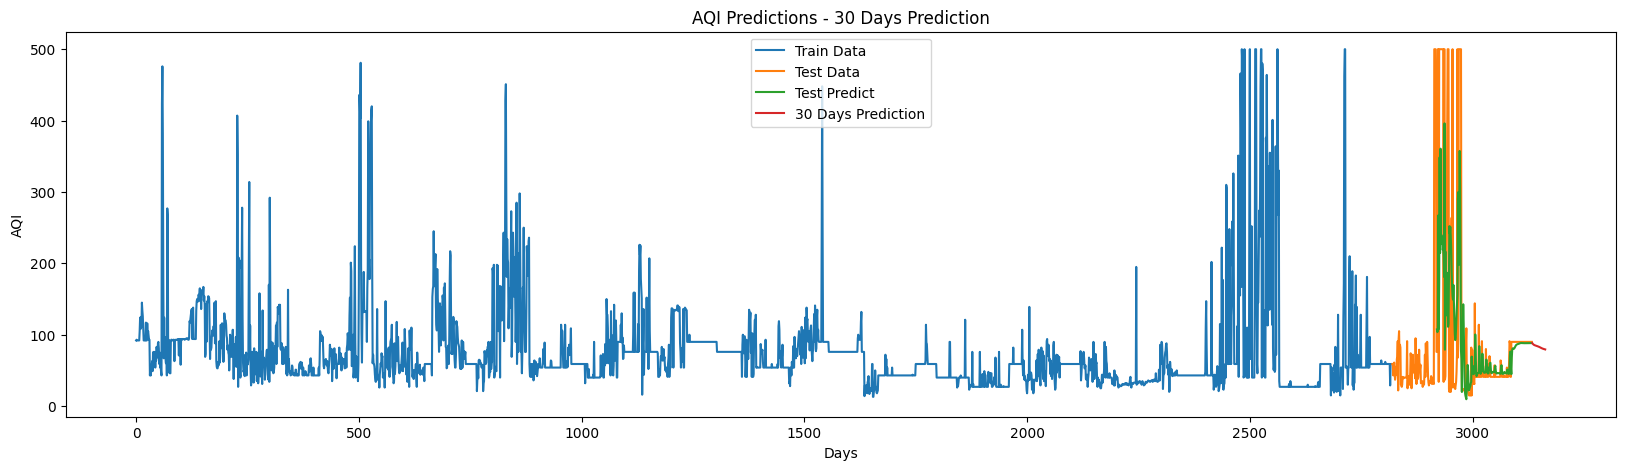

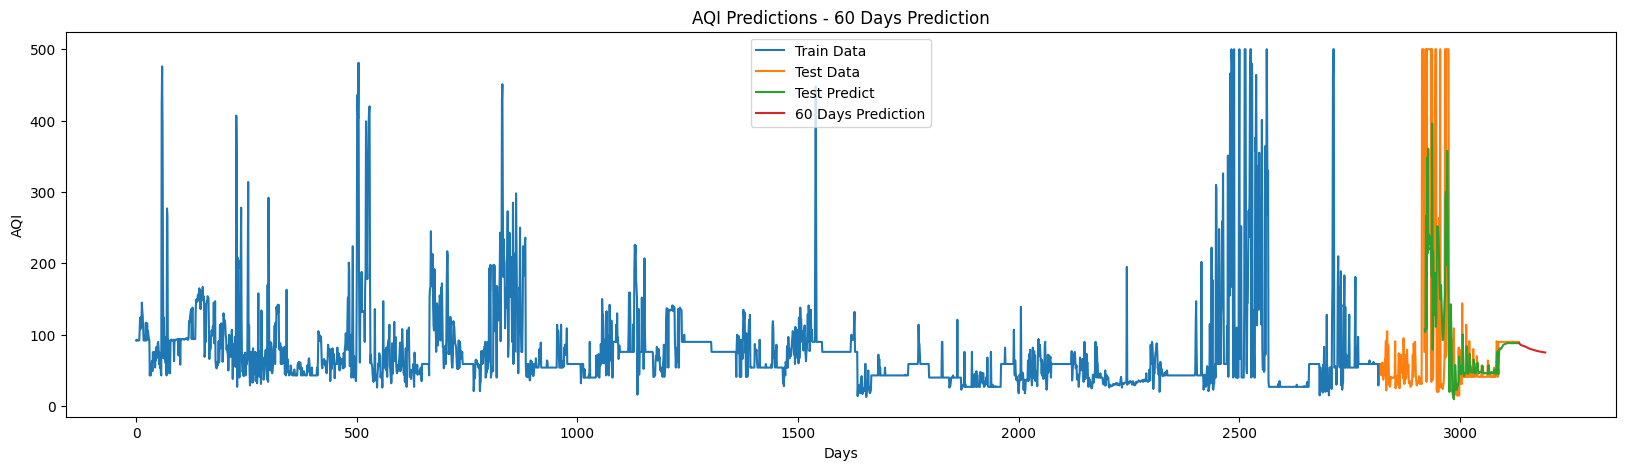

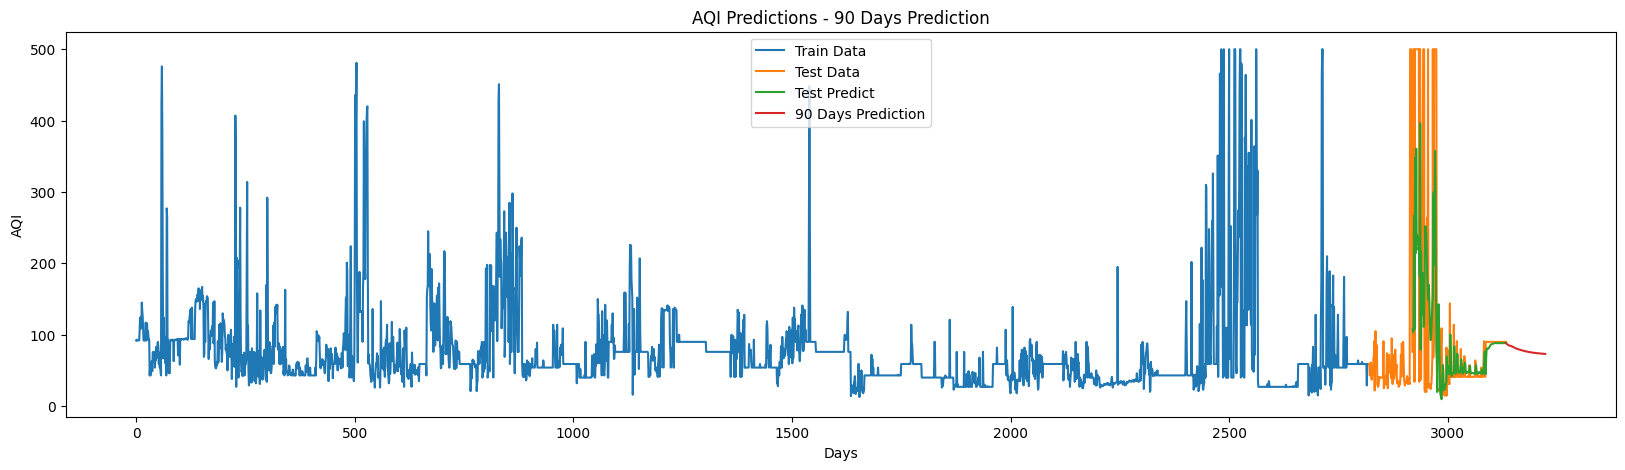

In [12]:
# 13. Tạo hàm dự đoán
def predict_future(model, data, time_step, future_days):
    temp_input = data[-time_step:].reshape(1, -1)
    temp_input = list(temp_input[0])
    future_output = []

    for _ in range(future_days):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]
        input_data = np.array(temp_input).reshape(1, time_step, 1)
        prediction = model.predict(input_data, verbose=0)
        temp_input.append(prediction[0][0])
        future_output.append(prediction[0][0])

    future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))
    return future_output

# 14. Dự đoán 30, 60, 90 ngày
future_30_days = predict_future(model, df1, time_step, 30)
future_60_days = predict_future(model, df1, time_step, 60)
future_90_days = predict_future(model, df1, time_step, 90)

# 15. Hàm trực quan dữ liệu
def create_plot(future_days, future_data, future_label):
    plt.figure(figsize=(20, 5))

    # Plot train data
    plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
    plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
    plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
    plt.plot(np.arange(len(df1), len(df1) + future_days), future_data, label=future_label)

    # Add labels and legend
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.title(f'AQI Predictions - {future_label}')
    plt.legend()
    plt.show()

# 16. Create plots
create_plot(30, future_30_days, '30 Days Prediction')
create_plot(60, future_60_days, '60 Days Prediction')
create_plot(90, future_90_days, '90 Days Prediction')

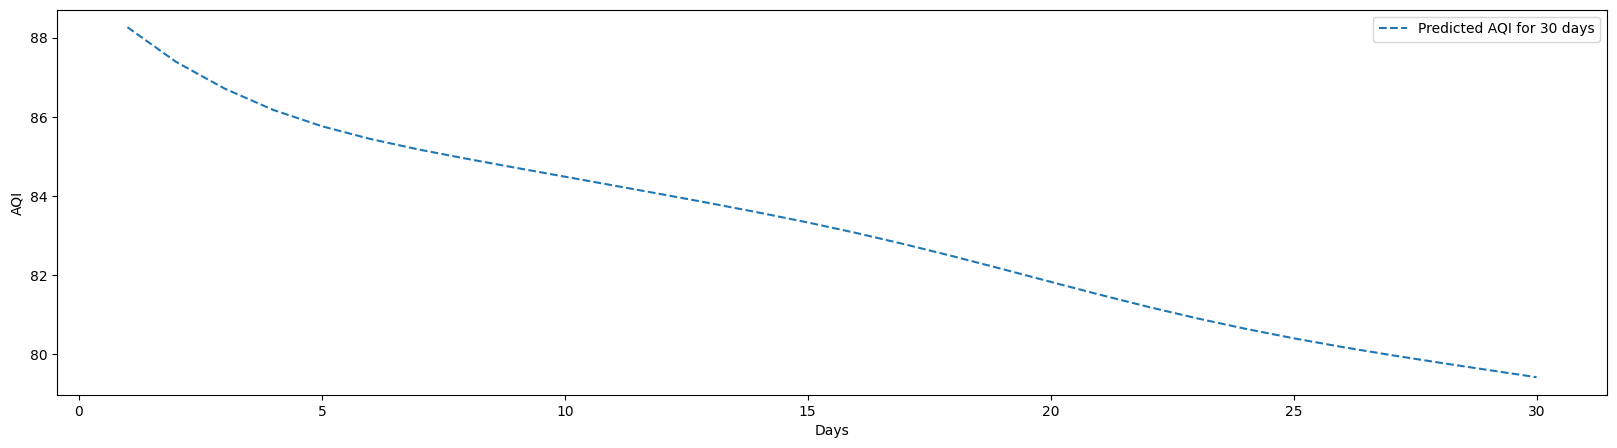

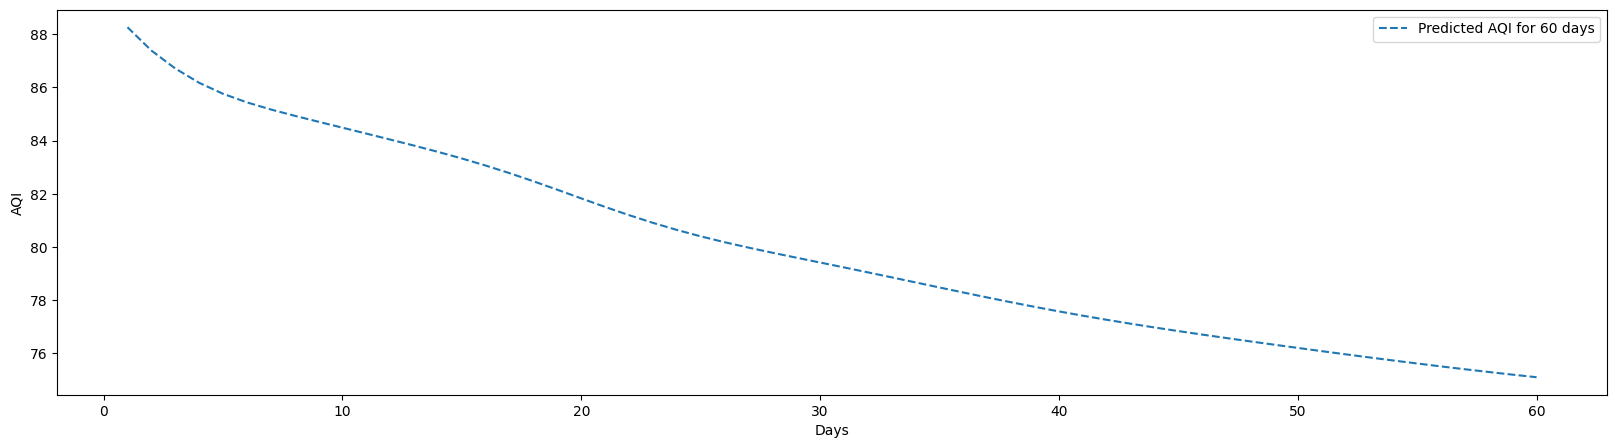

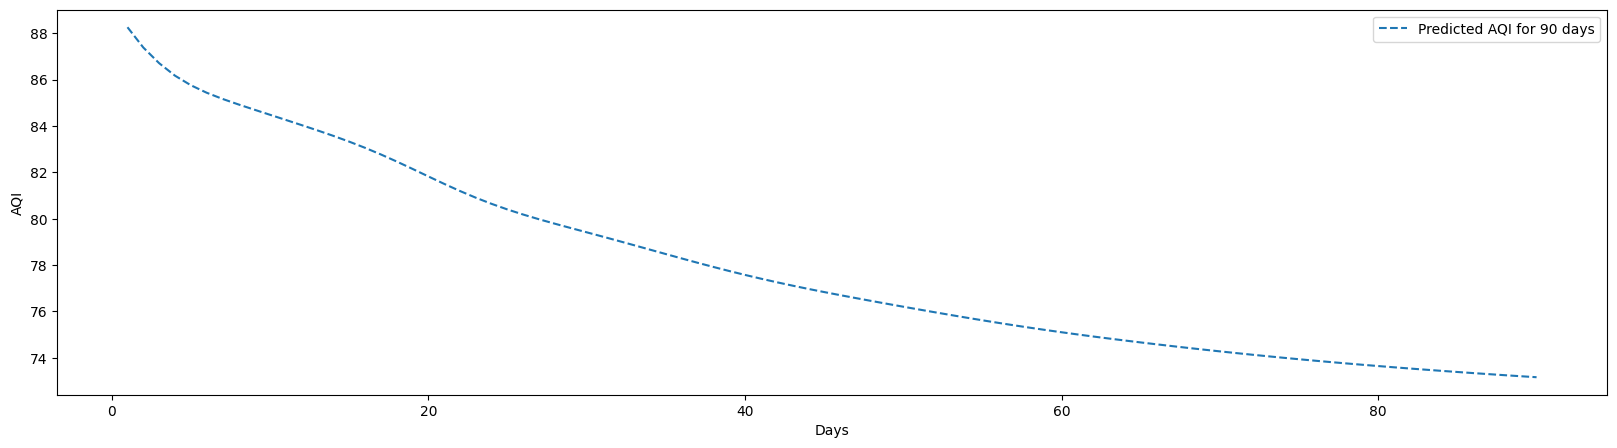

In [13]:
# Dự đoán chỉ số AQI theo 30. 60 và 90 ngày
for days in [30, 60, 90]:
    future_days = predict_future(model, df1, time_step, days)
    plt.figure(figsize=(20, 5))
    plt.plot(range(1, days + 1), future_days, label=f'Predicted AQI for {days} days', linestyle='--')
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()